In odrer to compare structured dropout and iid dropout in a linear model regime, we use the simulations embedded in sklearn (which make use of the Madelon synthetic dataset, see references in http://archive.ics.uci.edu/ml/datasets/madelon )
we vary: 
- the number of variables of redundant variables
- the number of overall variables 

we assess classification accuracy on a test set drawn from the same simulation



In [1]:
import sklearn
from sklearn.datasets import make_classification


import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')


x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
x_train=x_all[range(100),]
y_train=y_all[range(100),]
x_test=x_all[101:,]
y_test=y_all[101:]


dim = 1000 
nb_train = x_train.shape[0]
nb_test = x_test.shape[0]
nb_classes=1

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


print('x_train shape:', x_train.shape)
print(nb_train, 'train samples')
print(nb_test, 'test samples')

# Convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, nb_classes)
#y_test = to_categorical(y_test, nb_classes)

y_train=y_train.reshape(nb_train,1)
y_test=y_test.reshape(nb_test,1)

batch_size = 32

/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


x_train shape: (100, 1000)
100 train samples
10000 test samples


In [4]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc


def dropout_layer(x, mode, l, dim):

    if mode == 'struc':
        xm = tf.reduce_mean(x, 0)
        cov = tf.matmul(tf.transpose(x-xm), x-xm) / batch_size
        cov += 1e-2 * tf.eye(dim, dtype='float32')
       # dia=tf.sqrt(tf.diag(1/tf.diag_part(cov)))
       # corr= tf.matmul(tf.matmul(dia,cov),dia)
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'iid':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    else:  # no dropout
        return x


class Linear_Model:

    def __init__(self, dim, nb_classes, batch_size, l, mode=None):

        self.X = tf.placeholder(tf.float32, [None, dim])
        self.Y = tf.placeholder(tf.float32, [None, nb_classes])
        self.train = tf.placeholder(tf.bool)

        W = tf.Variable(tf.random_uniform([dim, nb_classes], -0.01, 0.01))  # model weights
        b = tf.Variable(tf.zeros(shape=[nb_classes]))                       # model biases

        self.dl = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
        x = tf.matmul(self.dl, W) + b

        # Minimize error using cross entropy
        self.probs = tf.nn.sigmoid(x)
        log_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=self.Y)
        self.mean_log_loss = tf.reduce_mean(log_loss)

def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies

For the training of the linear model, we simulate on 10 runs a set of 100 points with parameters listed in the paper, the model is either regularised using iid Gaussian dropout, Structured dropout (ASNI), or without regularisation. We test the model on each run, and for all regularisation parameters on one test dataset with 10,000 points, then average the accuracy on the 10 runs (and compute the standard deviation).   

In [5]:



max_iters = 2000 
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=100, n_informative=10, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 100
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

x_train shape: (100, 100)
100 train samples
10000 test samples
#### iid  #### iteration  0
Lamb 1e-06
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all

Iteration: 1000, 0.534
Accuracy: 0.564
Iteration: 1200, 0.293
Accuracy: 0.569
Iteration: 1400, 0.354
Accuracy: 0.558
Iteration: 1600, 0.532
Accuracy: 0.551
Iteration: 1800, 0.415
Accuracy: 0.556
#### no noise ####   iteration  0
Lamb None
Iteration: 0, 0.671
Accuracy: 0.525
Iteration: 200, 0.384
Accuracy: 0.675
Iteration: 400, 0.283
Accuracy: 0.673
Iteration: 600, 0.247
Accuracy: 0.672
Iteration: 800, 0.174
Accuracy: 0.670
Iteration: 1000, 0.134
Accuracy: 0.667
Iteration: 1200, 0.138
Accuracy: 0.663
Iteration: 1400, 0.104
Accuracy: 0.662
Iteration: 1600, 0.148
Accuracy: 0.658
Iteration: 1800, 0.124
Accuracy: 0.658
x_train shape: (100, 100)
100 train samples
10000 test samples
#### iid  #### iteration  1
Lamb 1e-06
Iteration: 0, 0.697
Accuracy: 0.547
Iteration: 200, 0.379
Accuracy: 0.688
Iteration: 400, 0.322
Accuracy: 0.672
Iteration: 600, 0.270
Accuracy: 0.666
Iteration: 800, 0.181
Accuracy: 0.662
Iteration: 1000, 0.139
Accuracy: 0.661
Iteration: 1200, 0.110
Accuracy: 0.660
Iteration:

Iteration: 1400, 0.075
Accuracy: 0.637
Iteration: 1600, 0.069
Accuracy: 0.635
Iteration: 1800, 0.040
Accuracy: 0.632
Lamb 0.01
Iteration: 0, 0.670
Accuracy: 0.565
Iteration: 200, 0.367
Accuracy: 0.645
Iteration: 400, 0.235
Accuracy: 0.643
Iteration: 600, 0.155
Accuracy: 0.642
Iteration: 800, 0.159
Accuracy: 0.638
Iteration: 1000, 0.113
Accuracy: 0.637
Iteration: 1200, 0.096
Accuracy: 0.635
Iteration: 1400, 0.098
Accuracy: 0.635
Iteration: 1600, 0.059
Accuracy: 0.633
Iteration: 1800, 0.064
Accuracy: 0.631
Lamb 0.1
Iteration: 0, 0.690
Accuracy: 0.489
Iteration: 200, 0.373
Accuracy: 0.636
Iteration: 400, 0.281
Accuracy: 0.643
Iteration: 600, 0.214
Accuracy: 0.642
Iteration: 800, 0.286
Accuracy: 0.639
Iteration: 1000, 0.143
Accuracy: 0.637
Iteration: 1200, 0.104
Accuracy: 0.636
Iteration: 1400, 0.229
Accuracy: 0.635
Iteration: 1600, 0.069
Accuracy: 0.634
Iteration: 1800, 0.110
Accuracy: 0.634
Lamb 1.0
Iteration: 0, 0.695
Accuracy: 0.432
Iteration: 200, 0.625
Accuracy: 0.634
Iteration: 400,

Accuracy: 0.538
Iteration: 200, 0.342
Accuracy: 0.691
Iteration: 400, 0.214
Accuracy: 0.691
Iteration: 600, 0.148
Accuracy: 0.694
Iteration: 800, 0.187
Accuracy: 0.692
Iteration: 1000, 0.096
Accuracy: 0.691
Iteration: 1200, 0.042
Accuracy: 0.689
Iteration: 1400, 0.066
Accuracy: 0.686
Iteration: 1600, 0.064
Accuracy: 0.686
Iteration: 1800, 0.030
Accuracy: 0.686
Lamb 0.001
Iteration: 0, 0.692
Accuracy: 0.575
Iteration: 200, 0.371
Accuracy: 0.689
Iteration: 400, 0.203
Accuracy: 0.693
Iteration: 600, 0.124
Accuracy: 0.693
Iteration: 800, 0.145
Accuracy: 0.691
Iteration: 1000, 0.137
Accuracy: 0.691
Iteration: 1200, 0.077
Accuracy: 0.688
Iteration: 1400, 0.058
Accuracy: 0.686
Iteration: 1600, 0.059
Accuracy: 0.686
Iteration: 1800, 0.042
Accuracy: 0.684
Lamb 0.01
Iteration: 0, 0.696
Accuracy: 0.604
Iteration: 200, 0.369
Accuracy: 0.688
Iteration: 400, 0.185
Accuracy: 0.689
Iteration: 600, 0.139
Accuracy: 0.689
Iteration: 800, 0.148
Accuracy: 0.688
Iteration: 1000, 0.096
Accuracy: 0.686
Iterat

Iteration: 1000, 0.072
Accuracy: 0.697
Iteration: 1200, 0.060
Accuracy: 0.697
Iteration: 1400, 0.048
Accuracy: 0.697
Iteration: 1600, 0.034
Accuracy: 0.697
Iteration: 1800, 0.029
Accuracy: 0.698


In [ ]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies


max_iters = 200 
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=100, n_informative=10, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 100
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

x_train shape: (100, 100)
100 train samples
10000 test samples
#### iid  #### iteration  0
Lamb 1e-06
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all

In [6]:
np.mean(acc_linear), np.std(acc_linear)

(0.6655, 0.0235405182610749)

In [7]:
np.mean(acc_iid), np.std(acc_iid)

(0.6834800000000001, 0.02014580849705467)

In [8]:
np.mean(acc_struc), np.std(acc_struc)

(0.6803999999999999, 0.01981706335459418)

In [9]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies


max_iters = 2000
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 1000
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

('x_train shape:', (100, 1000))
(100, 'train samples')
(10000, 'test samples')
('#### iid  #### iteration ', 0)
('Lamb', 1e-06)
Iteration: 0, 0.690
Accuracy: 0.558
Iteration: 200, 0.012
Accuracy: 0.712
Iteration: 400, 0.004
Accuracy: 0.712
Iteration: 600, 0.003
Accuracy: 0.711
Iteration: 800, 0.002
Accuracy: 0.712
Iteration: 1000, 0.001
Accuracy: 0.711
Iteration: 1200, 0.001
Accuracy: 0.711
Iteration: 1400, 0.001
Accuracy: 0.711
Iteration: 1600, 0.001
Accuracy: 0.711
Iteration: 1800, 0.000
Accuracy: 0.711
('Lamb', 1e-05)
Iteration: 0, 0.695
Accuracy: 0.521
Iteration: 200, 0.014
Accuracy: 0.709
Iteration: 400, 0.005
Accuracy: 0.709
Iteration: 600, 0.003
Accuracy: 0.709
Iteration: 800, 0.002
Accuracy: 0.708
Iteration: 1000, 0.001
Accuracy: 0.708
Iteration: 1200, 0.001
Accuracy: 0.708
Iteration: 1400, 0.001
Accuracy: 0.708
Iteration: 1600, 0.001
Accuracy: 0.708
Iteration: 1800, 0.000
Accuracy: 0.708
('Lamb', 0.0001)
Iteration: 0, 0.715
Accuracy: 0.519
Iteration: 200, 0.012
Accuracy: 0.712

Iteration: 1800, 0.000
Accuracy: 0.668
('Lamb', 0.1)
Iteration: 0, 0.740
Accuracy: 0.538
Iteration: 200, 0.020
Accuracy: 0.674
Iteration: 400, 0.007
Accuracy: 0.673
Iteration: 600, 0.006
Accuracy: 0.670
Iteration: 800, 0.004
Accuracy: 0.671
Iteration: 1000, 0.002
Accuracy: 0.671
Iteration: 1200, 0.002
Accuracy: 0.670
Iteration: 1400, 0.002
Accuracy: 0.669
Iteration: 1600, 0.001
Accuracy: 0.669
Iteration: 1800, 0.001
Accuracy: 0.670
('Lamb', 1.0)
Iteration: 0, 0.721
Accuracy: 0.536
Iteration: 200, 0.056
Accuracy: 0.652
Iteration: 400, 0.025
Accuracy: 0.635
Iteration: 600, 0.048
Accuracy: 0.630
Iteration: 800, 0.018
Accuracy: 0.633
Iteration: 1000, 0.005
Accuracy: 0.626
Iteration: 1200, 0.035
Accuracy: 0.616
Iteration: 1400, 0.034
Accuracy: 0.606
Iteration: 1600, 0.028
Accuracy: 0.603
Iteration: 1800, 0.001
Accuracy: 0.605
('#### struc #### iteration ', 1)
('Lamb', 1e-06)
Iteration: 0, 0.781
Accuracy: 0.522
Iteration: 200, 0.015
Accuracy: 0.680
Iteration: 400, 0.005
Accuracy: 0.680
Itera

('Lamb', 0.001)
Iteration: 0, 0.768
Accuracy: 0.525
Iteration: 200, 0.013
Accuracy: 0.699
Iteration: 400, 0.005
Accuracy: 0.699
Iteration: 600, 0.003
Accuracy: 0.699
Iteration: 800, 0.002
Accuracy: 0.698
Iteration: 1000, 0.001
Accuracy: 0.698
Iteration: 1200, 0.001
Accuracy: 0.698
Iteration: 1400, 0.001
Accuracy: 0.699
Iteration: 1600, 0.001
Accuracy: 0.699
Iteration: 1800, 0.000
Accuracy: 0.699
('Lamb', 0.01)
Iteration: 0, 0.738
Accuracy: 0.548
Iteration: 200, 0.015
Accuracy: 0.679
Iteration: 400, 0.007
Accuracy: 0.675
Iteration: 600, 0.004
Accuracy: 0.673
Iteration: 800, 0.002
Accuracy: 0.670
Iteration: 1000, 0.002
Accuracy: 0.668
Iteration: 1200, 0.002
Accuracy: 0.666
Iteration: 1400, 0.001
Accuracy: 0.666
Iteration: 1600, 0.001
Accuracy: 0.664
Iteration: 1800, 0.001
Accuracy: 0.662
('Lamb', 0.1)
Iteration: 0, 0.869
Accuracy: 0.479
Iteration: 200, 0.032
Accuracy: 0.567
Iteration: 400, 0.012
Accuracy: 0.550
Iteration: 600, 0.006
Accuracy: 0.542
Iteration: 800, 0.005
Accuracy: 0.537
I

Iteration: 0, 0.744
Accuracy: 0.501
Iteration: 200, 0.012
Accuracy: 0.645
Iteration: 400, 0.005
Accuracy: 0.647
Iteration: 600, 0.002
Accuracy: 0.647
Iteration: 800, 0.001
Accuracy: 0.647
Iteration: 1000, 0.001
Accuracy: 0.648
Iteration: 1200, 0.001
Accuracy: 0.648
Iteration: 1400, 0.001
Accuracy: 0.648
Iteration: 1600, 0.000
Accuracy: 0.648
Iteration: 1800, 0.000
Accuracy: 0.649
('Lamb', 1e-05)
Iteration: 0, 0.717
Accuracy: 0.544
Iteration: 200, 0.013
Accuracy: 0.654
Iteration: 400, 0.004
Accuracy: 0.652
Iteration: 600, 0.002
Accuracy: 0.652
Iteration: 800, 0.002
Accuracy: 0.651
Iteration: 1000, 0.001
Accuracy: 0.651
Iteration: 1200, 0.001
Accuracy: 0.651
Iteration: 1400, 0.001
Accuracy: 0.650
Iteration: 1600, 0.000
Accuracy: 0.650
Iteration: 1800, 0.000
Accuracy: 0.650
('Lamb', 0.0001)
Iteration: 0, 0.687
Accuracy: 0.540
Iteration: 200, 0.011
Accuracy: 0.646
Iteration: 400, 0.005
Accuracy: 0.646
Iteration: 600, 0.002
Accuracy: 0.646
Iteration: 800, 0.002
Accuracy: 0.647
Iteration: 10

In [10]:
np.mean(acc_linear), np.std(acc_linear)

(0.68056, 0.02296654958847756)

In [11]:
np.mean(acc_iid), np.std(acc_iid)

(0.6864600000000001, 0.020661229392269956)

In [12]:
np.mean(acc_struc), np.std(acc_struc)

(0.68758, 0.022539955634384)

In [6]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    #print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies


max_iters = 2000
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=10000, n_informative=1000, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 10000
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

x_train shape: (100, 10000)
100 train samples
10000 test samples
#### iid  #### iteration  0
Lamb 1e-06
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update a

ResourceExhaustedError: OOM when allocating tensor with shape[10000,10000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: cond/eye/MatrixDiag = MatrixDiag[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](cond/eye/ones)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'cond/eye/MatrixDiag', defined at:
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-cfb07ff18606>", line 88, in <module>
    acc_iid_i=training(lambdas, 'iid', max_iters)
  File "<ipython-input-6-cfb07ff18606>", line 11, in training
    model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
  File "<ipython-input-5-33aea1dcf6cd>", line 36, in __init__
    self.dl = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2048, in cond
    orig_res_t, res_t = context_t.BuildCondBranch(true_fn)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py", line 1895, in BuildCondBranch
    original_result = fn()
  File "<ipython-input-5-33aea1dcf6cd>", line 36, in <lambda>
    self.dl = tf.cond(self.train, lambda : dropout_layer(self.X, mode, l, dim), lambda : self.X)
  File "<ipython-input-5-33aea1dcf6cd>", line 17, in dropout_layer
    cov =  tf.eye(dim, dtype='float32')
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/ops/linalg_ops.py", line 167, in eye
    name=name)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/ops/linalg_ops_impl.py", line 68, in eye
    return array_ops.matrix_diag(diag_ones)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3950, in matrix_diag
    "MatrixDiag", diagonal=diagonal, name=name)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 454, in new_func
    return func(*args, **kwargs)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3155, in create_op
    op_def=op_def)
  File "/cbio/donnees/bkhalfaoui/miniconda3/envs/tensor_gpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1717, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[10000,10000] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: cond/eye/MatrixDiag = MatrixDiag[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](cond/eye/ones)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
np.mean(acc_linear), np.std(acc_linear)

In [ ]:
np.mean(acc_iid), np.std(acc_iid)

In [ ]:
np.mean(acc_struc), np.std(acc_struc)

In [4]:
def training(seqlambda, mode, max_iters=6000, learning_rate=1):

    all_accuracies = []
    all_cor_norms = []
    acts1 = []
    for lamb in seqlambda:

        print('Lamb', lamb)
        accs = [] ; cor_norms = [] 
        
        model = Linear_Model(dim, nb_classes, batch_size, lamb, mode)
        #model = MLP(dimension, nb_hidden1, nb_hidden2,nb_classes, batch_size, lamb, mode)

        # training parameters
        optimiser = tf.train.AdamOptimizer().minimize(model.mean_log_loss)
        #optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(model.mean_log_loss)
        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())

            for iters in range(max_iters):

                idx = np.random.randint(nb_train, size=batch_size)

                _, loss,train_probs = sess.run([optimiser, model.mean_log_loss,model.probs], feed_dict={
                    model.X : x_train[idx], model.Y : y_train[idx], model.train : True})
                acc = np.sum(np.round(train_probs) == y_train[idx]) / float(128)
               # print("train_accuracy",acc)
                #print(np.sum(err1))
                #print(np.sum(err2))
            

                if iters % 200 == 0:
                    print('Iteration: %d, %.03f' % (iters, loss))  
                    pred= sess.run([model.probs],
                                    feed_dict={model.X : x_test, model.train : False})
                 
                    acc = np.sum(np.round(pred) == y_test) / float(nb_test)
                    accs.append(acc)
                    print('Accuracy: %.03f' % acc)
            
            all_accuracies.append(accs)


    return all_accuracies


max_iters = 2000
lambdas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0]



acc_linear=[]
acc_iid=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=100, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 1000
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

    print('#### iid  #### iteration ',i)
    acc_iid_i=training(lambdas, 'iid', max_iters)
    acc_iid.append([np.max([np.max(acc) for acc in acc_iid_i])])

    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    print('#### no noise ####   iteration ',i)
    acc_linear_i=training([None], None , max_iters)
    acc_linear.append([accs[-1] for accs in acc_linear_i])

x_train shape: (100, 1000)
100 train samples
10000 test samples
#### iid  #### iteration  0
Lamb 1e-06
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update al

Iteration: 1000, 0.603
Accuracy: 0.549
Iteration: 1200, 1.443
Accuracy: 0.530
Iteration: 1400, 1.505
Accuracy: 0.528
Iteration: 1600, 4.662
Accuracy: 0.529
Iteration: 1800, 17.571
Accuracy: 0.524
#### no noise ####   iteration  0
Lamb None
Iteration: 0, 1.041
Accuracy: 0.528
Iteration: 200, 0.006
Accuracy: 0.697
Iteration: 400, 0.003
Accuracy: 0.699
Iteration: 600, 0.001
Accuracy: 0.701
Iteration: 800, 0.001
Accuracy: 0.700
Iteration: 1000, 0.001
Accuracy: 0.700
Iteration: 1200, 0.000
Accuracy: 0.701
Iteration: 1400, 0.000
Accuracy: 0.701
Iteration: 1600, 0.000
Accuracy: 0.702
Iteration: 1800, 0.000
Accuracy: 0.702
x_train shape: (100, 1000)
100 train samples
10000 test samples
#### iid  #### iteration  1
Lamb 1e-06
Iteration: 0, 0.829
Accuracy: 0.493
Iteration: 200, 0.005
Accuracy: 0.644
Iteration: 400, 0.003
Accuracy: 0.644
Iteration: 600, 0.001
Accuracy: 0.643
Iteration: 800, 0.001
Accuracy: 0.643
Iteration: 1000, 0.000
Accuracy: 0.644
Iteration: 1200, 0.000
Accuracy: 0.644
Iteratio

Iteration: 1200, 0.000
Accuracy: 0.696
Iteration: 1400, 0.000
Accuracy: 0.696
Iteration: 1600, 0.000
Accuracy: 0.696
Iteration: 1800, 0.000
Accuracy: 0.696
Lamb 0.01
Iteration: 0, 1.519
Accuracy: 0.470
Iteration: 200, 0.005
Accuracy: 0.682
Iteration: 400, 0.002
Accuracy: 0.685
Iteration: 600, 0.001
Accuracy: 0.687
Iteration: 800, 0.000
Accuracy: 0.690
Iteration: 1000, 0.000
Accuracy: 0.690
Iteration: 1200, 0.000
Accuracy: 0.690
Iteration: 1400, 0.000
Accuracy: 0.691
Iteration: 1600, 0.000
Accuracy: 0.691
Iteration: 1800, 0.000
Accuracy: 0.692
Lamb 0.1
Iteration: 0, 0.778
Accuracy: 0.568
Iteration: 200, 0.015
Accuracy: 0.698
Iteration: 400, 0.003
Accuracy: 0.698
Iteration: 600, 0.001
Accuracy: 0.699
Iteration: 800, 0.002
Accuracy: 0.700
Iteration: 1000, 0.001
Accuracy: 0.701
Iteration: 1200, 0.001
Accuracy: 0.702
Iteration: 1400, 0.000
Accuracy: 0.704
Iteration: 1600, 0.000
Accuracy: 0.703
Iteration: 1800, 0.001
Accuracy: 0.702
Lamb 1.0
Iteration: 0, 1.547
Accuracy: 0.568
Iteration: 200

Lamb 0.0001
Iteration: 0, 0.809
Accuracy: 0.548
Iteration: 200, 0.014
Accuracy: 0.620
Iteration: 400, 0.008
Accuracy: 0.626
Iteration: 600, 0.002
Accuracy: 0.626
Iteration: 800, 0.003
Accuracy: 0.624
Iteration: 1000, 0.002
Accuracy: 0.625
Iteration: 1200, 0.001
Accuracy: 0.626
Iteration: 1400, 0.002
Accuracy: 0.628
Iteration: 1600, 0.000
Accuracy: 0.628
Iteration: 1800, 0.000
Accuracy: 0.626
Lamb 0.001
Iteration: 0, 1.361
Accuracy: 0.524
Iteration: 200, 0.021
Accuracy: 0.623
Iteration: 400, 0.008
Accuracy: 0.631
Iteration: 600, 0.011
Accuracy: 0.630
Iteration: 800, 0.003
Accuracy: 0.631
Iteration: 1000, 0.002
Accuracy: 0.632
Iteration: 1200, 0.002
Accuracy: 0.631
Iteration: 1400, 0.001
Accuracy: 0.630
Iteration: 1600, 0.001
Accuracy: 0.629
Iteration: 1800, 0.001
Accuracy: 0.630
Lamb 0.01
Iteration: 0, 3.102
Accuracy: 0.564
Iteration: 200, 0.075
Accuracy: 0.631
Iteration: 400, 0.018
Accuracy: 0.625
Iteration: 600, 0.008
Accuracy: 0.622
Iteration: 800, 0.004
Accuracy: 0.616
Iteration: 10

KeyboardInterrupt: 

In [11]:
np.mean(acc_linear), np.std(acc_linear)

(0.65832, 0.016279975429956867)

In [12]:
np.mean(acc_iid), np.std(acc_iid)

(0.67628, 0.013198393841676362)

In [13]:
np.mean(acc_struc), np.std(acc_struc)

(0.68212, 0.013086389876509098)

We also compare fast structured dropout with structured dropout version : 

In [8]:
from tensorflow.contrib.distributions import MultivariateNormalFullCovariance as mvnfc


def dropout_layer(x, mode, l, dim):

    if mode == 'struc':
        xm = tf.reduce_mean(x, 0)
        cov = tf.matmul(tf.transpose(x-xm), x-xm) / batch_size
        cov += 1e-2 * tf.eye(dim, dtype='float32')
       # dia=tf.sqrt(tf.diag(1/tf.diag_part(cov)))
       # corr= tf.matmul(tf.matmul(dia,cov),dia)
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))
 
    elif mode == 'struc_fast':
       #mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        xm = tf.reduce_mean(x, 0)
        sample = tf.distributions.Normal(loc=tf.zeros(shape=[dim]),scale= tf.ones(shape=[dim])).sample()
        a= tf.expand_dims(sample,1)
        sample =  tf.matmul((x-xm),a)/ np.sqrt(batch_size)
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    elif mode == 'iid':
      # mu = tf.Variable(lambda : tf.ones(shape=[dim]))
        cov =  tf.eye(dim, dtype='float32')
        sample = mvnfc(tf.zeros(shape=[dim]), cov).sample()
        return tf.multiply(x, np.sqrt(l)* sample + tf.ones(shape=[dim]))

    else:  # no dropout
        return x

In [5]:
from time import time
max_iters = 2000
lambdas = [1e-2]


acc_fstruc=[]
acc_struc=[]

for i in range(5):            
    x_all, y_all= sklearn.datasets.make_classification(n_samples=10101, n_features=1000, n_informative=100, n_redundant=100, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    x_train=x_all[range(100),]
    y_train=y_all[range(100),]
    x_test=x_all[101:,]
    y_test=y_all[101:]


    dim = 1000
    nb_train = x_train.shape[0]
    nb_test = x_test.shape[0]
    nb_classes=1

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')


    print('x_train shape:', x_train.shape)
    print(nb_train, 'train samples')
    print(nb_test, 'test samples')

    # Convert class vectors to binary class matrices.
    #y_train = to_categorical(y_train, nb_classes)
    #y_test = to_categorical(y_test, nb_classes)

    y_train=y_train.reshape(nb_train,1)
    y_test=y_test.reshape(nb_test,1)

    batch_size = 32

 
    print('#### fast_struc  #### iteration ',i)
    t0 = time()
    acc_fstruc_i=training(lambdas, 'iid', max_iters)
    acc_fstruc.append([np.max([np.max(acc) for acc in acc_fstruc_i])])
    t1 = time()
    print('#### struc #### iteration ',i)
    acc_struc_i=training(lambdas, 'struc', max_iters)
    acc_struc.append([np.max([np.max(acc) for acc in acc_struc_i])])
    t2 = time()


x_train shape: (100, 1000)
100 train samples
10000 test samples
#### fast_struc  #### iteration  0
Lamb 0.01
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should upd

In [6]:
np.mean(acc_struc), np.std(acc_struc)

(0.6711, 0.022516482851457947)

In [7]:
np.mean(acc_fstruc), np.std(acc_fstruc)

(0.6693399999999998, 0.02531233691305489)

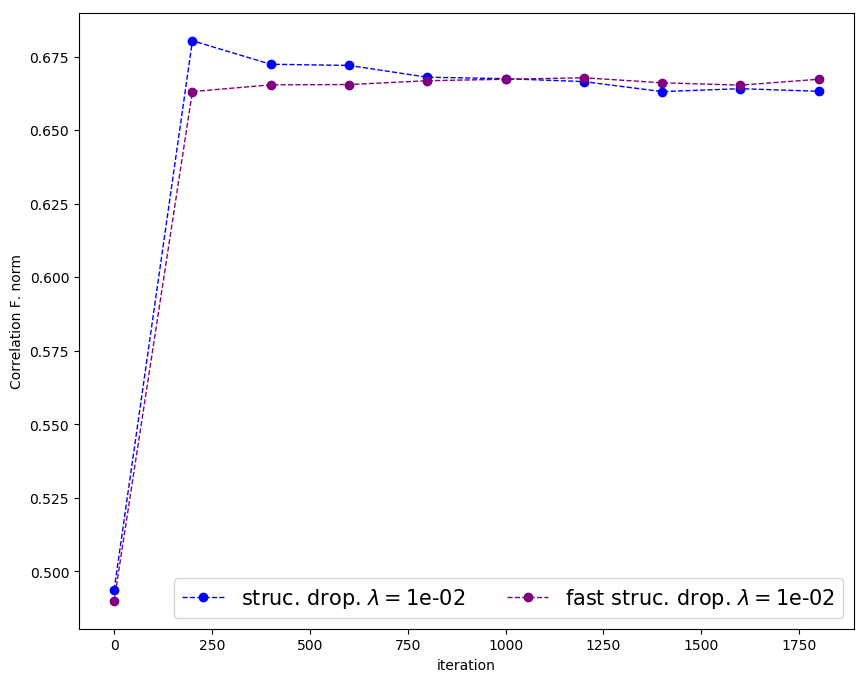

In [13]:
sns.reset_orig()

fig, ax = plt.subplots(figsize=(10, 8))

line_styles = ['--o', '--*', '--.','--+',':']

for i, series in enumerate(acc_struc_i):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='blue', linewidth=1,
            label=r'struc. drop. $\lambda=$%.0e' % lambdas[i])
    
for i, series in enumerate(acc_fstruc_i):
    ax.plot(np.arange(0, max_iters, 200), series,
            line_styles[i], color='purple', linewidth=1,
            label=r'fast struc. drop. $\lambda=$%.0e' % lambdas[i])


ax.set_xlabel('iteration')
ax.set_ylabel('Correlation F. norm')

# ax.set_ylim([0.8, 1.0])

plt.legend(ncol=2,prop={'size': 15})
plt.show()

In [14]:
print('average time for Fast structured dropout: ',t1-t0)

average time for Fast structured dropout:  3.4186959266662598


In [15]:
print('average time for  structured dropout: ',t2-t1)

average time for  structured dropout:  7.841660737991333
